Для работы с алгоритмами машинного обучения нужен некоторый способ векторизации — представления текста в виде набора числовых признаков. Ранее мы рассматривали методы "мешок слов" и TF-IDF, которые позволяют получить счетные векторы.

❌ Признаковое пространство имеет размерность, равную мощности словаря,
т.е. тысячи и десятки тысяч. Эта размерность растёт вместе с ростом словаря.

❌ Никак не учитывается семантическая близость слов, все векторы одинаково далеки друг от друга в признаковом пространстве.

Сегодня мы познакомимся со сжатыми векторными представлениями слов (word embeddings).

✅ Строятся в пространствах фиксированной размерности порядка десятков и сотен.

✅ Для семантически близких слов близки как векторы (например, по косинусной мере).

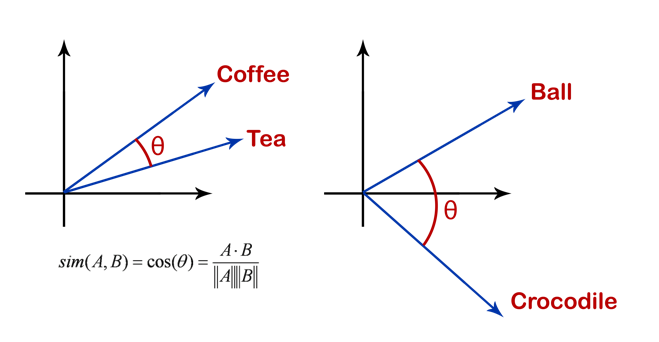

**Word2vec** — группа алгоритмов для получения векторных представлений слов.

[Оригинальная статья](https://arxiv.org/pdf/1301.3781.pdf)

Две модели:
- **Continuous Bag-of-Words (CBOW)** предсказывает текущее слово на основе его контекста (окружающих слов);

- **Skip-gram** предсказывает контекст (окружающие слова) на основе текущего слова.

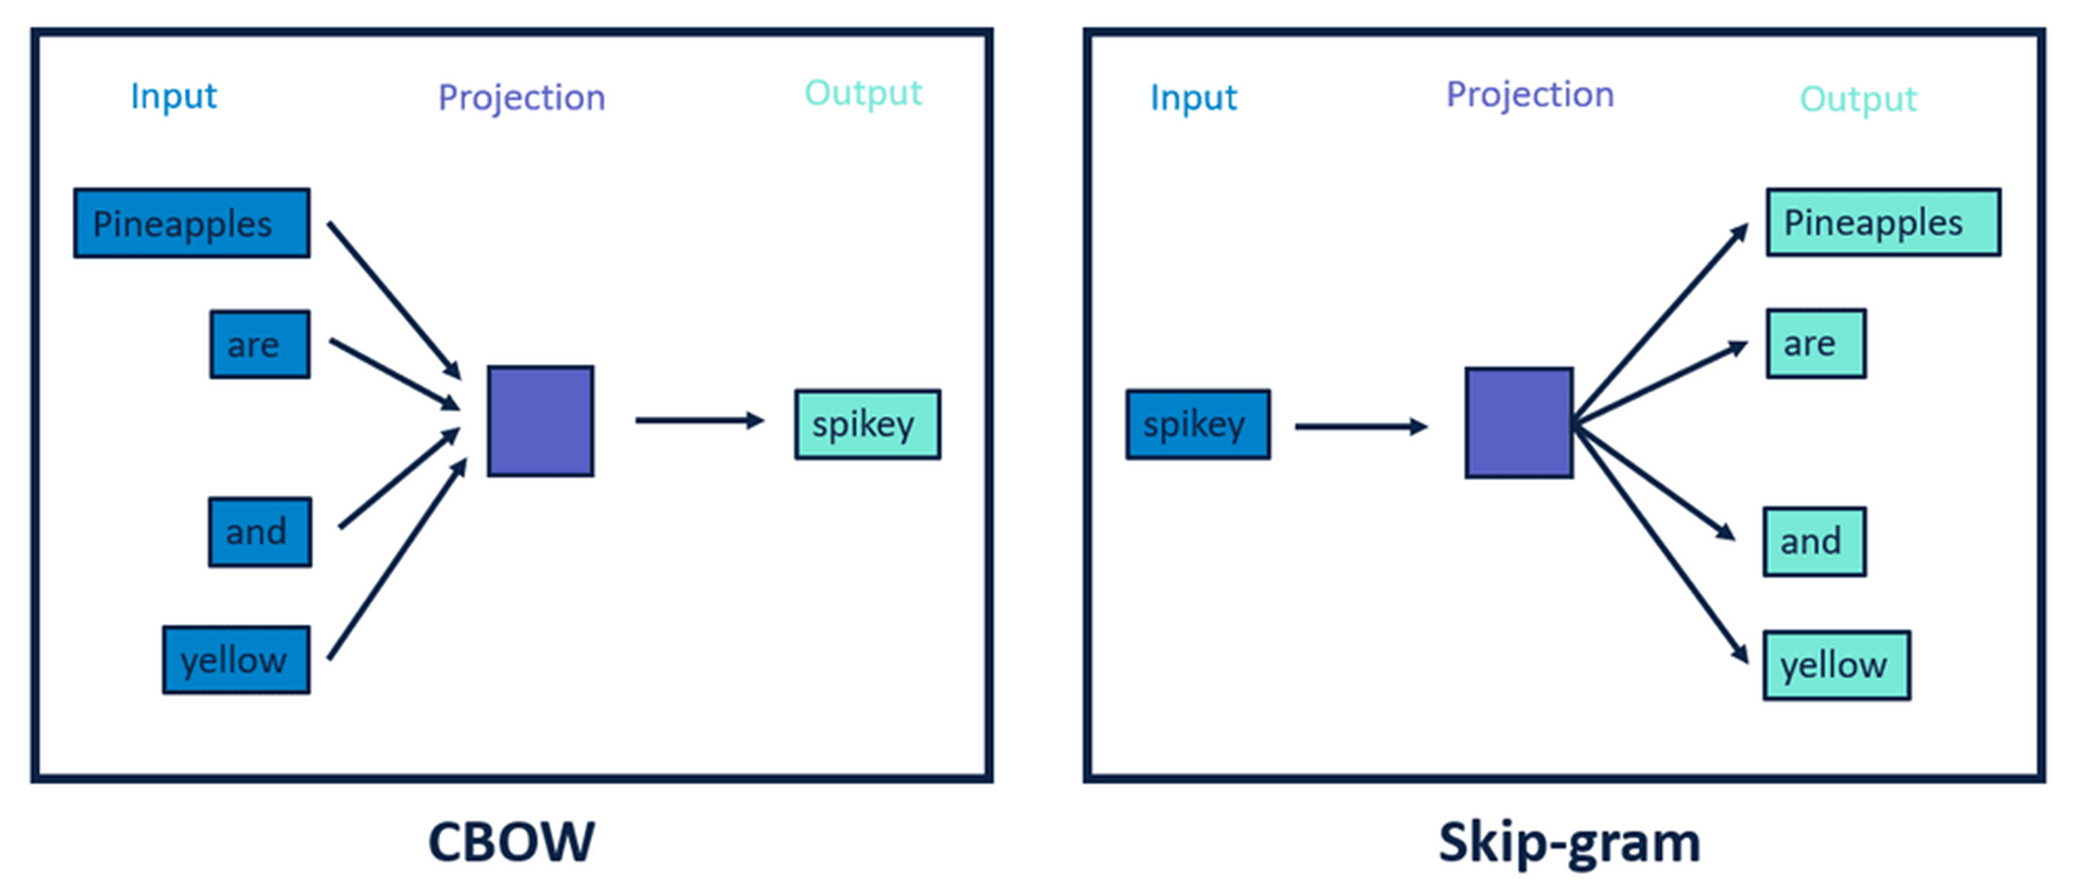

Обе модели решают задачу многоклассовой классификации с помощью персептрона с одним скрытым слоем. Для каждого слова в словаре мы должны получить вероятность, что оно соответствует данному контексту или само является контекстом.

При обучении модели происходит оптимизация весов. Именно они впоследствии используются как векторные представления слов.

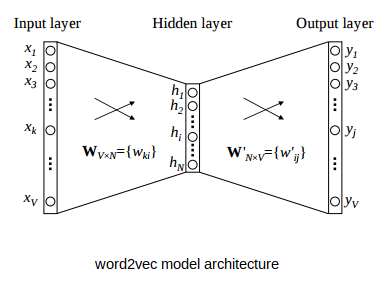

## Skip-gram

Рассмотрим получение сжатых векторных представлений на примере модели Skip-gram, поскольку она чаще используется на практике и дает лучшие результаты.

### Теоретическая часть

Пусть наш корпус состоит из одного предложения. Размер окна контекста — 1, смотрим на одно слово слева и одно слово справа.

📌 Каким будет размер словаря?

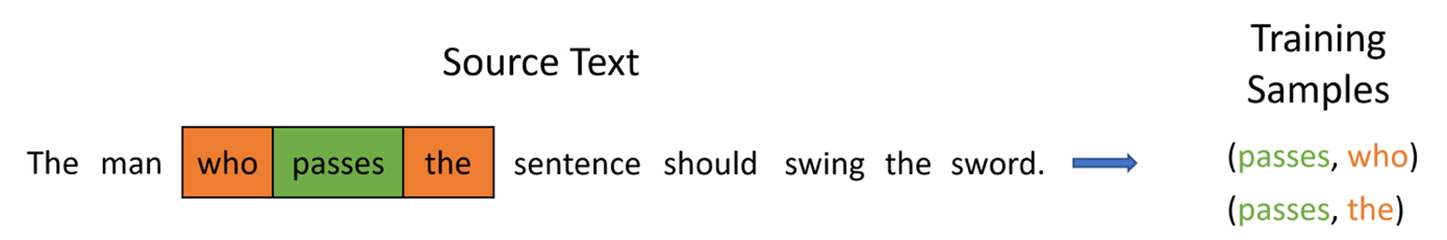

1) На вход мы подаем one-hot вектор $x$ для слова "passes" размера $V$.

2) Входной вектор умножается на матрицу со случайными значениями $W_{input}$ размера $V \times N$, где $V$ — размер словаря, $N$ — размер будущих эмбеддингов, который устанавливается самостоятельно (для больших моделей 300). После завершения обучения строки этой матрицы будут соответствовать сжатым векторам слов.

3) В результате перемножения получаем вектор $h$ размера $N$. Это внутреннее представление модели о слове "passes".

4) Получившийся ранее вектор $h$ умножается на новую матрицу со случайными значениями $W_{output}^T$ размера $N \times V$.

5) В результате перемножения получаем некоторый вектор размера $V$. Применяем к нему функцию активации softmax, после чего получаем новый вектор  $y_{pred}$. Он содержит вероятности для каждого слова быть контекстом входного слова "passes".

6) Подсчитаем ошибку для предсказанных значений. Для этого из вектора $y_{pred}$ вычтем вектор правильных ответов $y_{true}$.

7) Затем мы складываем два получившихся вектора и получаем суммированную ошибку.

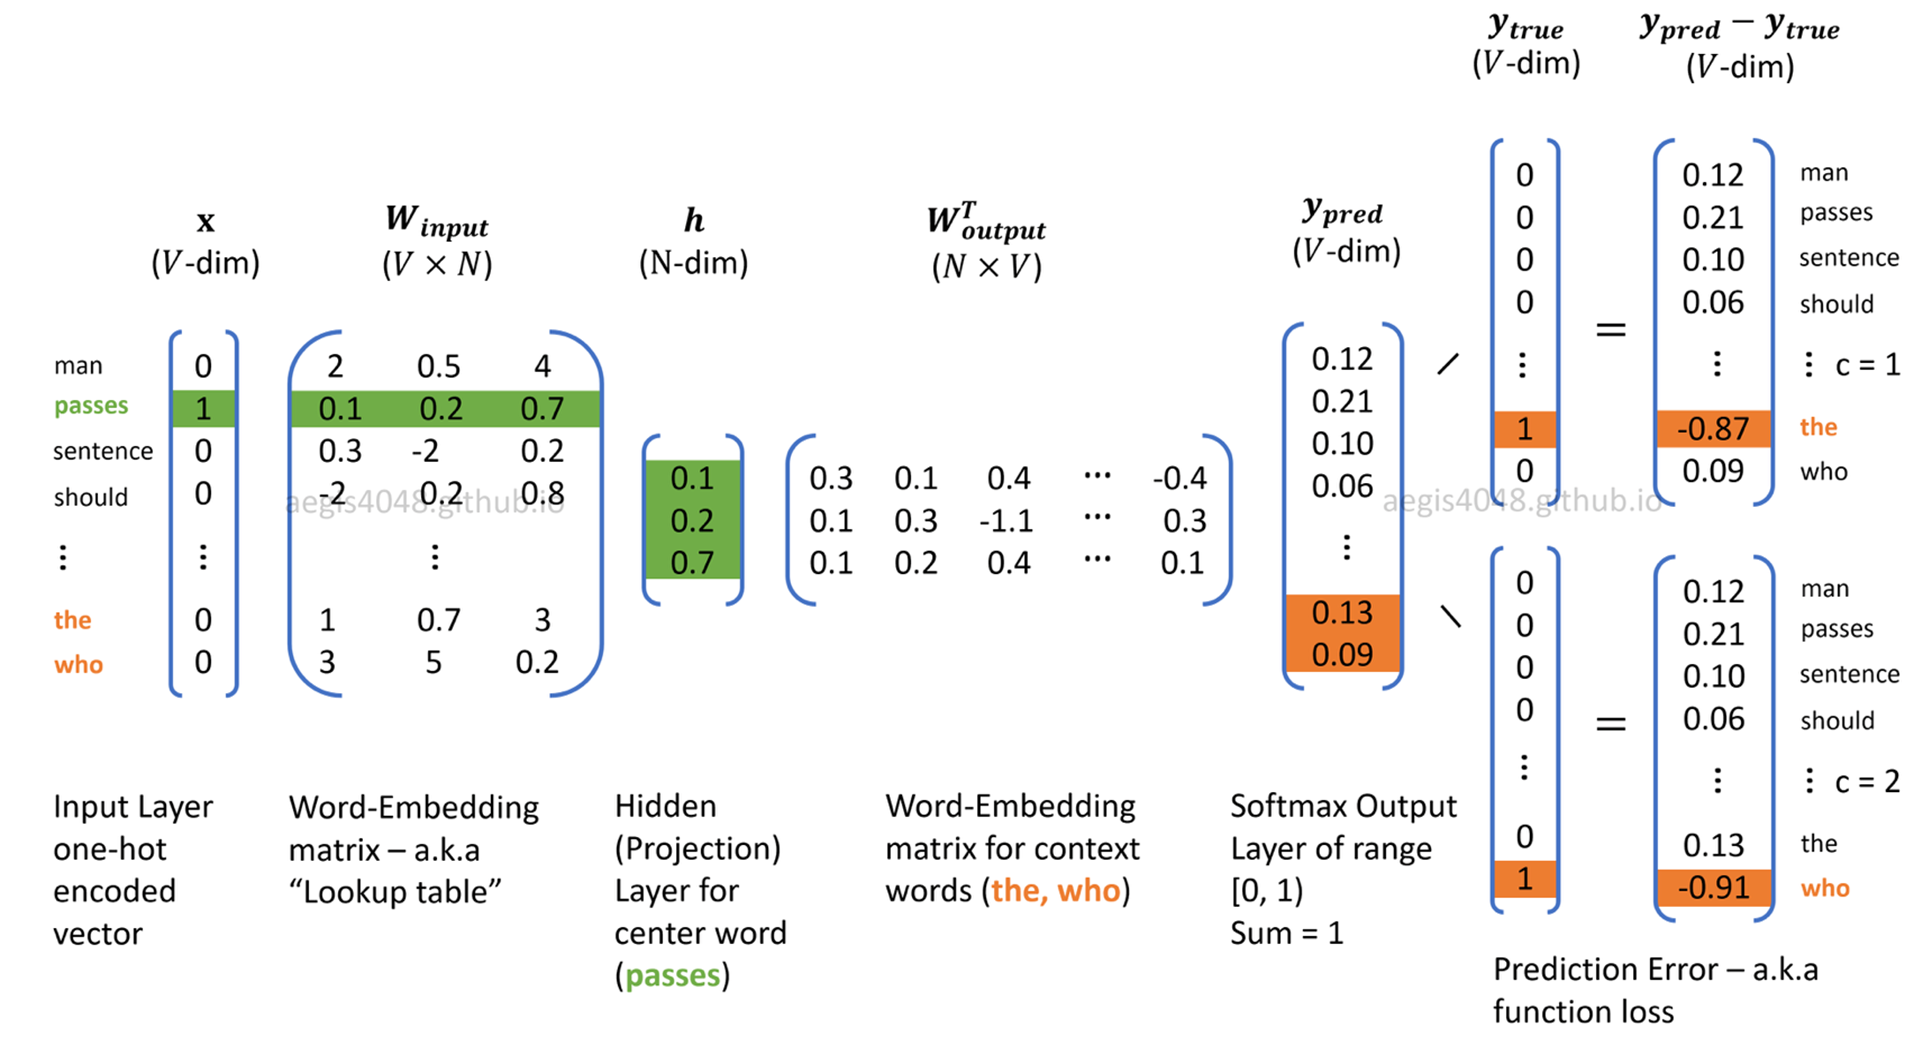

#### Forward

Умножение вектора на веса скрытого слоя

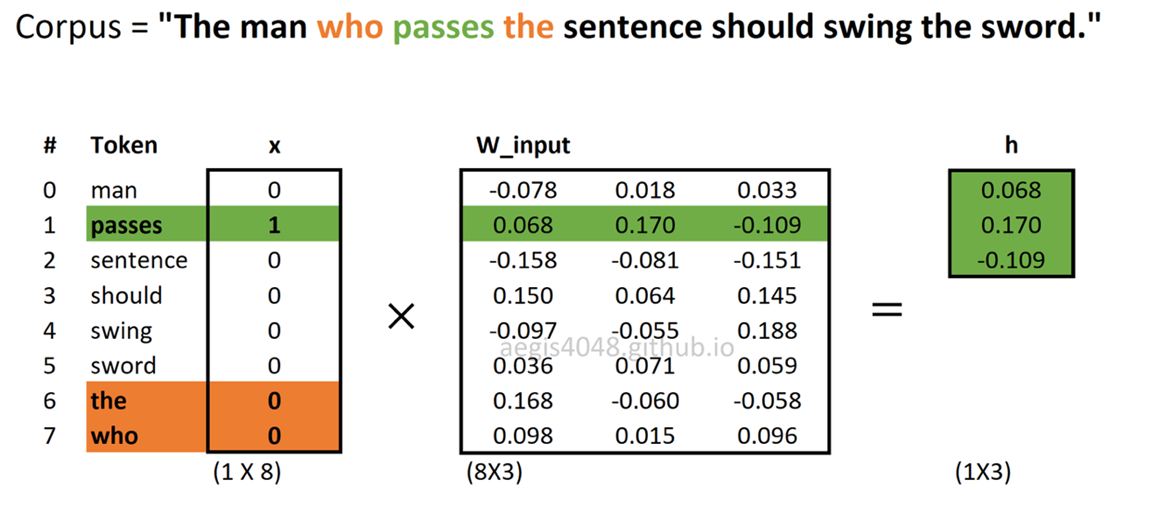

Умножение вектора (результата скрытого слоя) на веса выходного слоя

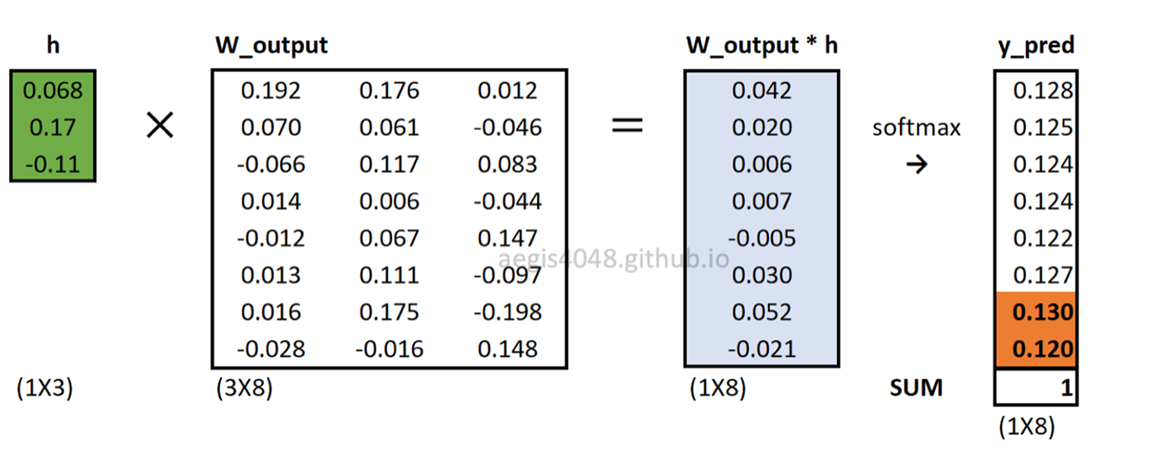

#### Backward

Подсчет суммированной ошибки

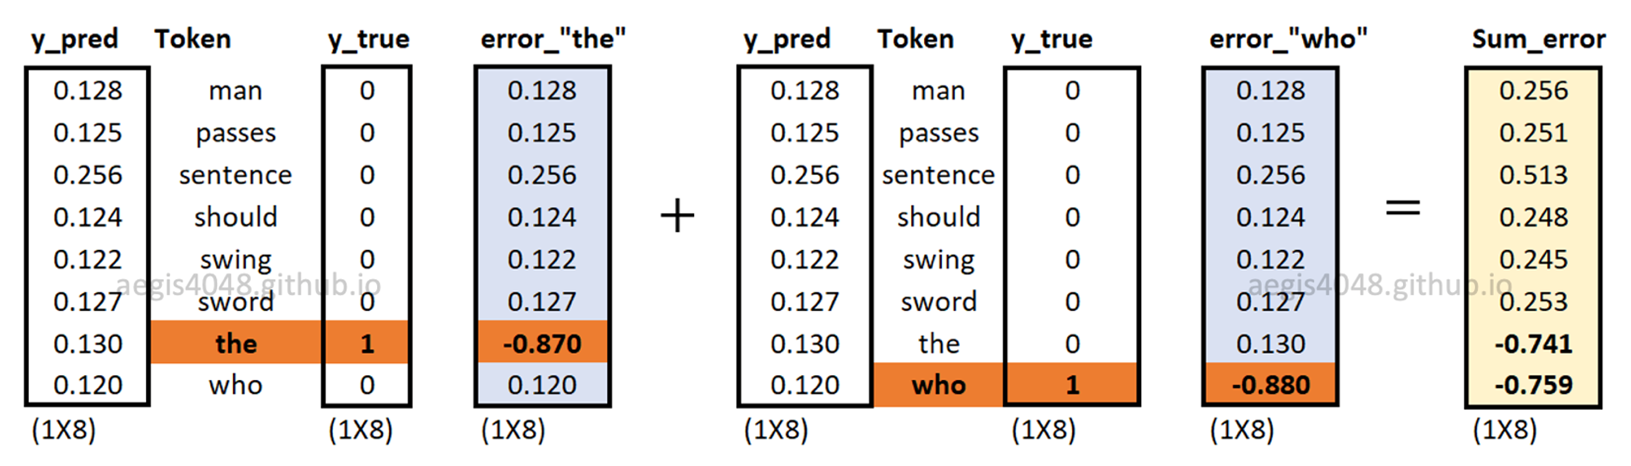

Подсчет градиента для $W_{input}$

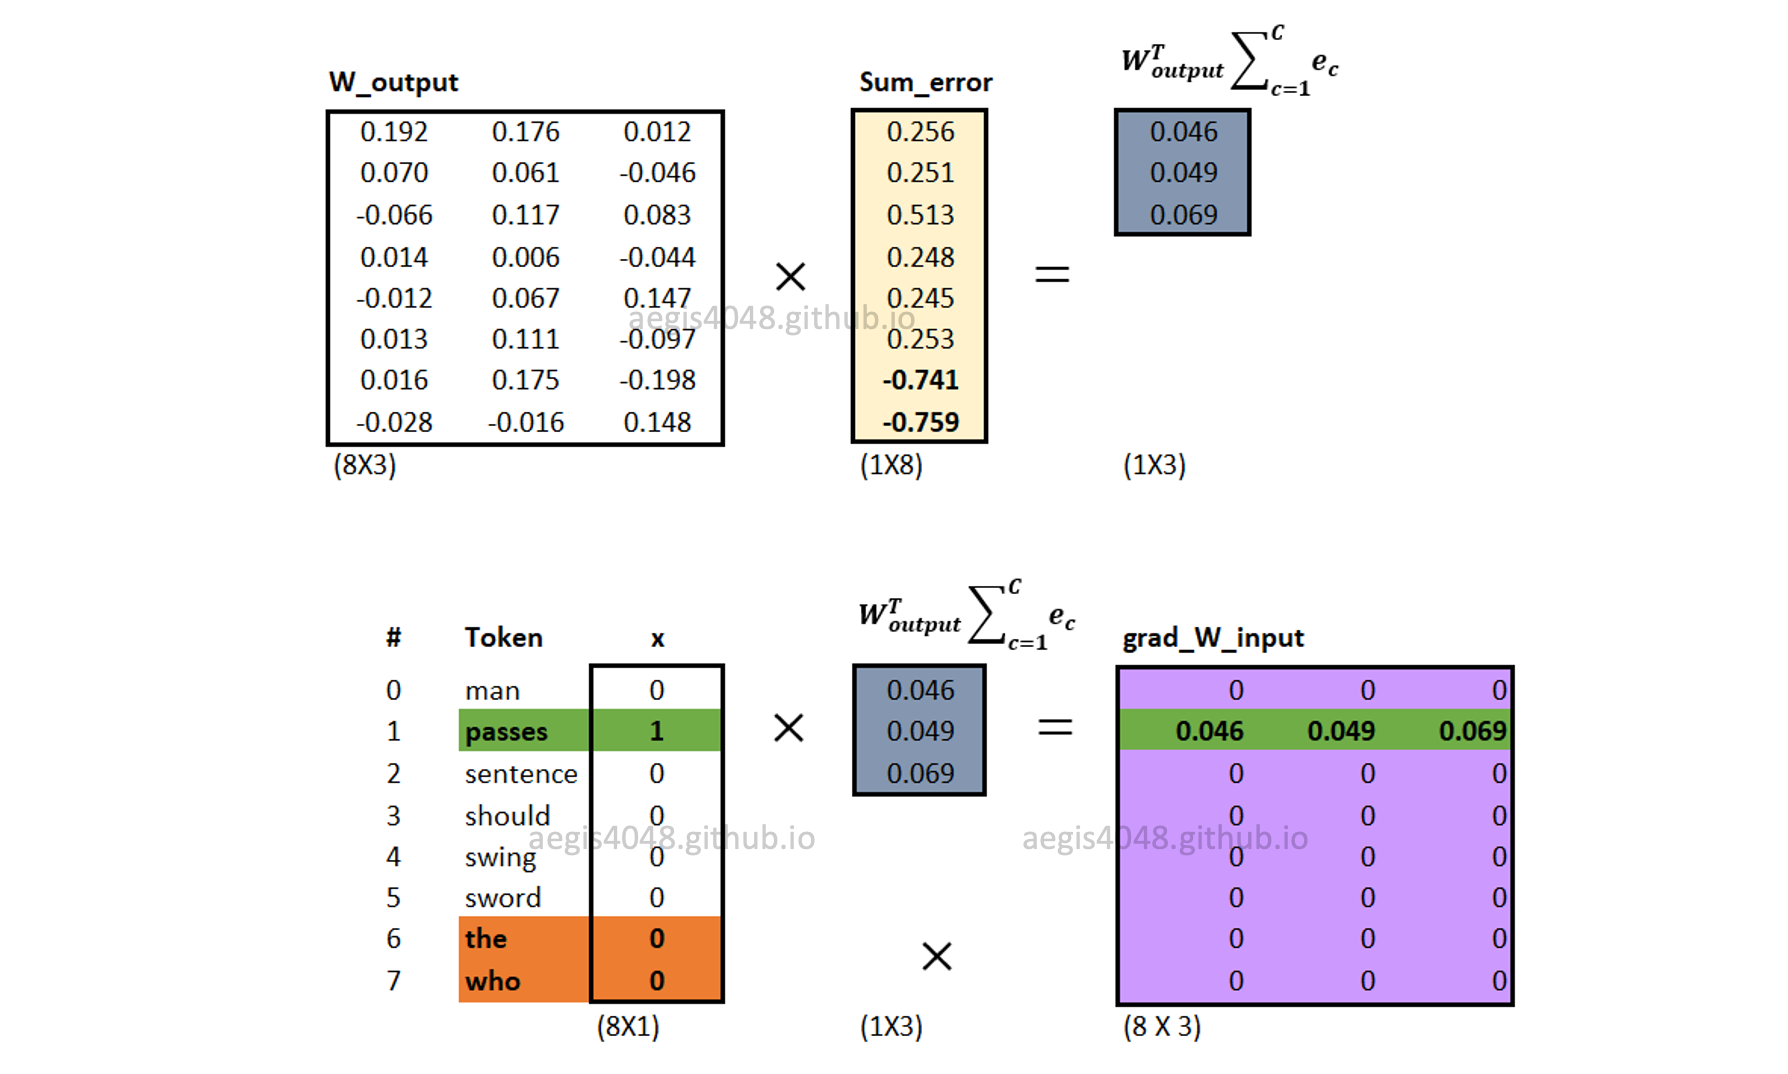

Подсчет градиента для $W^T_{output}$

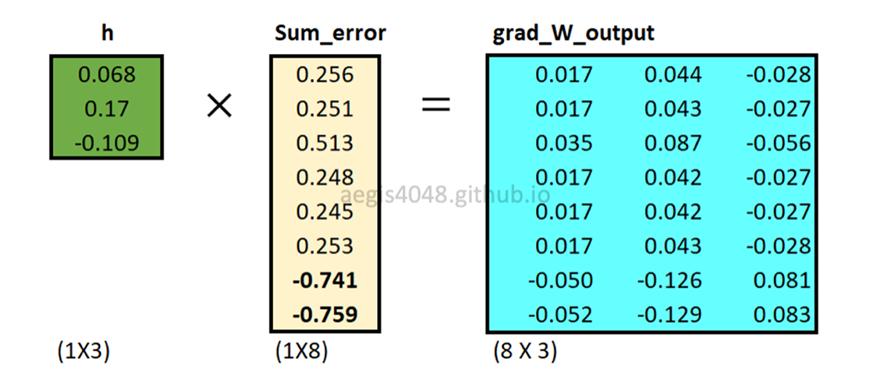

Обновление весов (градиентный спуск)

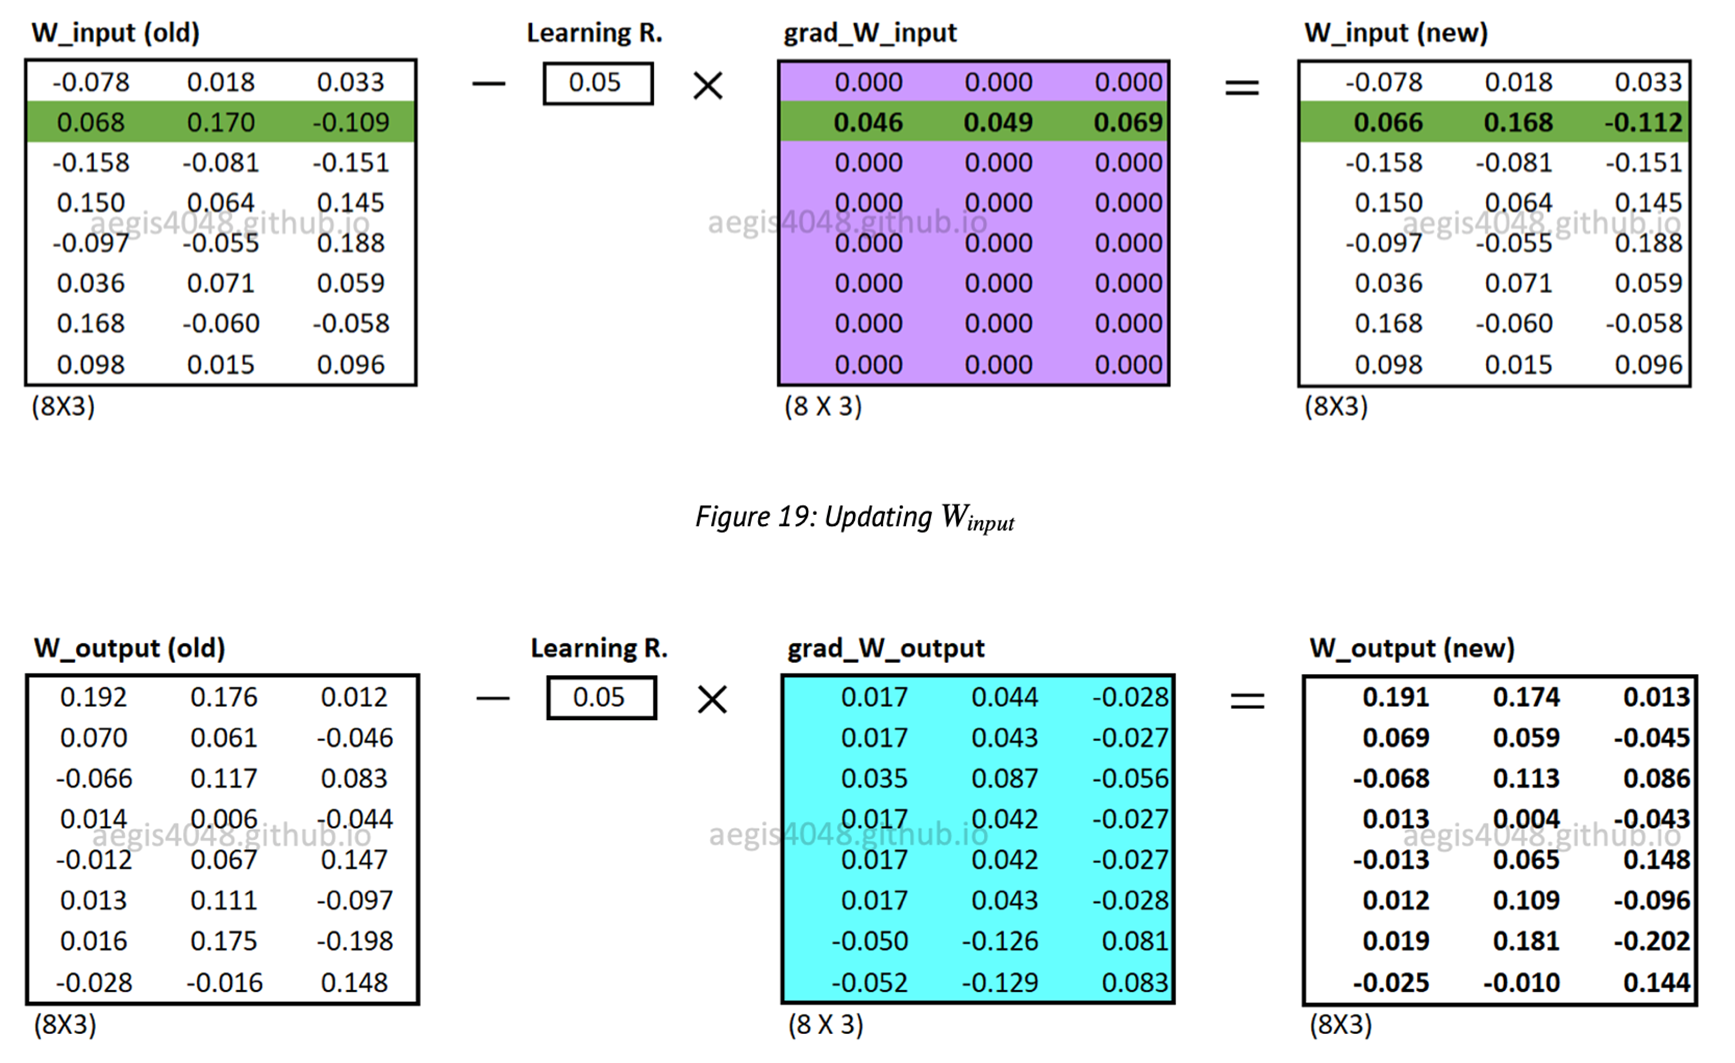

📌 В чем проблема такого подхода?

### Практическая часть

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import decomposition

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Подготовка данных

Определим наш небольшой корпус.

In [2]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

📌 Напишем функцию для предобработки одного предложения. Разделим предложение по словам (`.split()`) и удалим слоп-слова (`not in stop_words`).

In [3]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Место для вашего кода
    tokens = [token for token in text.split() if token not in stop_words]
    return tokens

Применим предобработку ко всем предложениям корпуса.

In [4]:
corpus = [preprocess(sentence) for sentence in corpus]
print(corpus)

[['drink', 'milk'], ['drink', 'cold', 'water'], ['drink', 'cold', 'cola'], ['drink', 'juice'], ['drink', 'cola'], ['eat', 'bacon'], ['eat', 'mango'], ['eat', 'cherry'], ['eat', 'apple'], ['juice', 'sugar'], ['cola', 'sugar'], ['mango', 'fruit'], ['apple', 'fruit'], ['cherry', 'fruit'], ['Berlin', 'Germany'], ['Boston', 'USA'], ['Mercedes', 'Germany'], ['Mercedes', 'car'], ['Ford', 'USA'], ['Ford', 'car']]


📌 Создадим словарь уникальных токенов `vocabulary` класса `Counter()`.

In [5]:
vocabulary = Counter()
# Место для вашего кода
for sentence in corpus:
  vocabulary.update(sentence)
print('Всего уникальных токенов:', len(vocabulary))

Всего уникальных токенов: 20


📌 Cоздадим словарь с индексами `word2id`: каждому слову (ключу) присвоим его порядковый номер (значение).

In [6]:
word2id = {}
# Место для вашего кода
for word in vocabulary:
  word2id[word] = len(word2id)
print(word2id)

{'drink': 0, 'milk': 1, 'cold': 2, 'water': 3, 'cola': 4, 'juice': 5, 'eat': 6, 'bacon': 7, 'mango': 8, 'cherry': 9, 'apple': 10, 'sugar': 11, 'fruit': 12, 'Berlin': 13, 'Germany': 14, 'Boston': 15, 'USA': 16, 'Mercedes': 17, 'car': 18, 'Ford': 19}


Для обучения модели skip-gram необходимо на вход подавать центральное слово и на выходе получать одно из слов контекста в заданном диапазоне (`window`). Создадим датафрейм, где будет две колонки: `Input` — центральное слово, `Output` — слово контекста.

In [7]:
def prepare_data(corpus, window):
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,word in enumerate(sentence):
            input = word
            for n in range(1, window+1):
                # смотрим контекст слева
                if (i-n)>=0:
                    output = sentence[i-n]
                    row = pd.DataFrame([[input,output]], columns = columns)
                    result = result.append(row, ignore_index = True)
                # смотрим контекст справа
                if (i+n)<len(sentence):
                    output = sentence[i+n]
                    row = pd.DataFrame([[input,output]], columns = columns)
                    result = result.append(row, ignore_index = True)
    return result

In [8]:
train_emb = prepare_data(corpus, window = 2)
train_emb.head(10)

Input Output
0  drink   milk
1   milk  drink
2  drink   cold
3  drink  water
4   cold  drink
5   cold  water
6  water   cold
7  water  drink
8  drink   cold
9  drink   cola

In [9]:
train_emb.shape[0]

48

В получившемся датафрейме заменим слова на их индексы из словаря `word2id`.

In [10]:
train_emb.Input = train_emb.Input.map(word2id)
train_emb.Output = train_emb.Output.map(word2id)
train_emb.head(10)

Input  Output
0      0       1
1      1       0
2      0       2
3      0       3
4      2       0
5      2       3
6      3       2
7      3       0
8      0       2
9      0       4

#### Обучение модели

Укажем размер эмбеддингов и размер словаря.

In [11]:
embedding_dim = 5
vocab_size = len(vocabulary)

Поскольку в нашем корпусе мало примеров, нам необходимо самостоятельно инициализировать веса небольшими значениями. Матрица `W_input` содержит веса скрытого слоя, матрица `W_output` — веса выходного слоя.

`Variable` — это надстройка над `Tensor`, которая позволяет подсчитывать градиенты для обратного распространения ошибки.

In [12]:
initrange = 0.5 / embedding_dim
W_input = Variable(torch.randn(vocab_size, embedding_dim).uniform_(-initrange, initrange).float(), requires_grad=True) # V x N
W_output = Variable(torch.randn(embedding_dim, vocab_size).uniform_(-initrange, initrange).float(), requires_grad=True) # N x V
print(W_input)
print(W_input.shape)
print(W_output)
print(W_output.shape)

tensor([[-0.0883, -0.0555,  0.0470,  0.0803, -0.0812],
        [ 0.0702, -0.0933, -0.0156,  0.0646,  0.0736],
        [-0.0078,  0.0525, -0.0546, -0.0481, -0.0079],
        [-0.0293,  0.0997, -0.0375,  0.0066, -0.0713],
        [ 0.0597, -0.0072, -0.0744, -0.0726,  0.0229],
        [-0.0702,  0.0190, -0.0871, -0.0267, -0.0490],
        [-0.0374, -0.0143,  0.0409, -0.0312, -0.0446],
        [-0.0840, -0.0270,  0.0248, -0.0977,  0.0594],
        [-0.0472, -0.0634, -0.0008, -0.0013,  0.0922],
        [ 0.0243, -0.0977, -0.0760,  0.0055, -0.0141],
        [-0.0913, -0.0915, -0.0033, -0.0828,  0.0369],
        [-0.0405, -0.0137,  0.0254, -0.0320, -0.0871],
        [ 0.0095, -0.0511,  0.0570,  0.0508,  0.0935],
        [-0.0394, -0.0861,  0.0221,  0.0963,  0.0449],
        [-0.0905, -0.0669,  0.0412,  0.0596, -0.0637],
        [ 0.0494,  0.0644, -0.0367, -0.0256,  0.0927],
        [-0.0616, -0.0928, -0.0895, -0.0636, -0.0855],
        [ 0.0450,  0.0893,  0.0790,  0.0349, -0.0914],
        [-

- Определим количество эпох и скорость обучения

- Зададим функцию потерь для многоклассовой классификации

In [13]:
num_epochs = 1000
learning_rate = 0.2
lr_decay = 0.99
criterion = nn.CrossEntropyLoss()
loss_hist = []

Напишем цикл для обучения по количеству эпох.

- Переведем данные `x` в one-hot тезнор `input_tensor`

📌 Скрытый слой: умножим входной тензор на матрицу весов `W_input`

📌 Выходной слой: умножим результат скрытого слоя на матрицу весов `W_output`(матричное умножение: `.mm()` или`@`)

📌 Примените функцию потерь, которую определили ранее (`criterion`)

- Запустим метод обратного распространения ошибки

- Будем самостоятельно обновлять веса методом градиентного спуска, обновляя значения весов матриц `W_input` и `W_output`

- Изначально мы задали довольно высокую скорость обучения. Будем уменьшать скорость обучения для каждой 10-й эпохи

- Будем выводить значение функции потерь для каждой 50-й эпохи

In [14]:
%%time
for epoch in range(num_epochs):
    for x,y in zip(torch.tensor([train_emb.Input.values]), torch.tensor([train_emb.Output.values])):

        # one-hot кодирование входного вектора
        input_tensor = F.one_hot(x).type(torch.Tensor)

        # скрытый слой 1 x N: умножение входного вектора на матрицу W_input
        h = input_tensor @ W_input # Место для вашего кода
        #h = input_tensor.mm(W_input)

        # выходной слой 1 x V: умножение результата скрытого слоя на матрицу W_output
        y_pred = h @ W_output # Место для вашего кода
        #y_pred = h.mm(W_output)

        # функция потерь
        loss = criterion(y_pred, y) # Место для вашего кода

        # обратное распространение ошибки
        loss.backward()

        # обновление весов с помощью метода градиентного спуска
        with torch.no_grad():
            W_input[x, :] -= learning_rate * W_input.grad.data[x, :]
            W_output -= learning_rate * W_output.grad.data
            W_input.grad.data.zero_()
            W_output.grad.data.zero_()

    # для каждой 10-й эпохи будем уменьшать скорость обучения
    if epoch % 10 == 0:
        learning_rate *= lr_decay

    # запишем значение функции потерь
    loss_hist.append(loss)

    # вывод ошибки для каждой 50-й эпохи
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, loss = {loss}')

Epoch 0, loss = 2.994866132736206
Epoch 50, loss = 2.986776351928711
Epoch 100, loss = 2.9701521396636963
Epoch 150, loss = 2.928659677505493
Epoch 200, loss = 2.830540657043457
Epoch 250, loss = 2.6404483318328857
Epoch 300, loss = 2.385676383972168
Epoch 350, loss = 2.1557066440582275
Epoch 400, loss = 1.9748271703720093
Epoch 450, loss = 1.830339789390564
Epoch 500, loss = 1.7050977945327759
Epoch 550, loss = 1.5921694040298462
Epoch 600, loss = 1.4931672811508179
Epoch 650, loss = 1.4106183052062988
Epoch 700, loss = 1.3437529802322388
Epoch 750, loss = 1.2896860837936401
Epoch 800, loss = 1.2455406188964844
Epoch 850, loss = 1.209108591079712
Epoch 900, loss = 1.178760051727295
Epoch 950, loss = 1.153282880783081
CPU times: user 626 ms, sys: 5.06 ms, total: 631 ms
Wall time: 707 ms


Получившиеся векторы имеют размерность 5. Чтобы отобразить их на графике, необходимо уменьшить размерность до 2. Сделаем это с помощью [сингулярного разложения](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

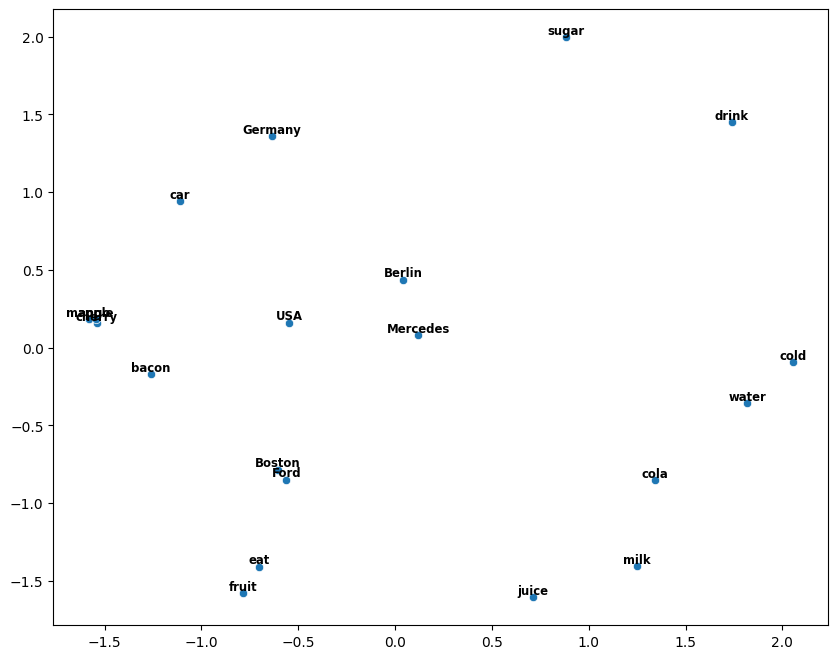

In [15]:
W_input = W_input.detach().numpy()
svd = decomposition.TruncatedSVD(n_components=2)
W_input_dec = svd.fit_transform(W_input)
x = W_input_dec[:,0]
y = W_input_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0, W_input_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

📌 Какие выводы можно сделать о получившихся векторных представлениях?

In [16]:
word2id

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bacon': 7,
 'mango': 8,
 'cherry': 9,
 'apple': 10,
 'sugar': 11,
 'fruit': 12,
 'Berlin': 13,
 'Germany': 14,
 'Boston': 15,
 'USA': 16,
 'Mercedes': 17,
 'car': 18,
 'Ford': 19}

Посчитаем косинусное расстояние между векторами слов 'mango' и 'apple', 'mango' и 'car'.

📌 Запишите векторы для этих слов по индексам в матрице `W_input`.

In [17]:
W_input = torch.Tensor(W_input)
mango = W_input[8, :] # Место для вашего кода
apple = W_input[10, :] # Место для вашего кода
car = W_input[18, :] # Место для вашего кода
mango_apple = F.cosine_similarity(mango, apple, dim=0)
print(mango_apple)
mango_car = F.cosine_similarity(mango, car, dim=0)
print(mango_car)

tensor(0.9991)
tensor(0.1852)


## Negative sampling

Поскольку классический word2vec решает задачу многоклассовой классификации, при обучении модели пересчитываются веса для всех слов в словаре. Чтобы сократить количество вычислений, было предложено использовать бинарную классификацию.

Если раньше необходимо было предсказывать контекст для слова, то теперь для двух слов необходимо предсказать, являются они соседними или нет.

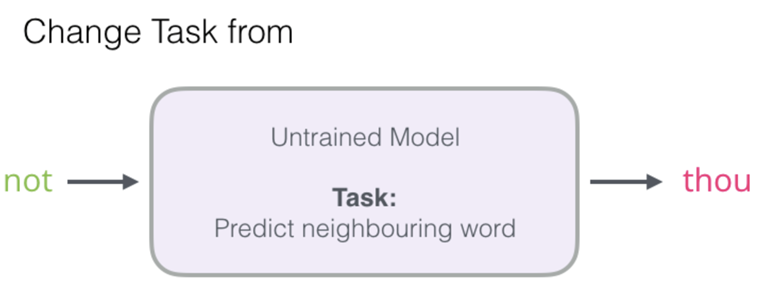

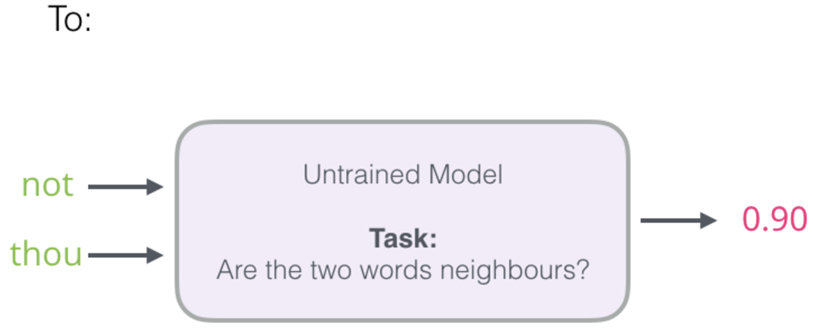

📌 Какая проблема возникнет, если для обучения использовать только положительные примеры? Как ее решить?

Теперь корпус выглядит по-другому: на вход мы подаем пары слов и метку 1 или 0 (являются ли они соседними).

Чтобы получить примеры отрицательного класса,
для каждого целевого слова в пару добавляются случайные слова, которые не являются соседними. На каждый правильный пример добавляется от 5 до 20 неправильных.

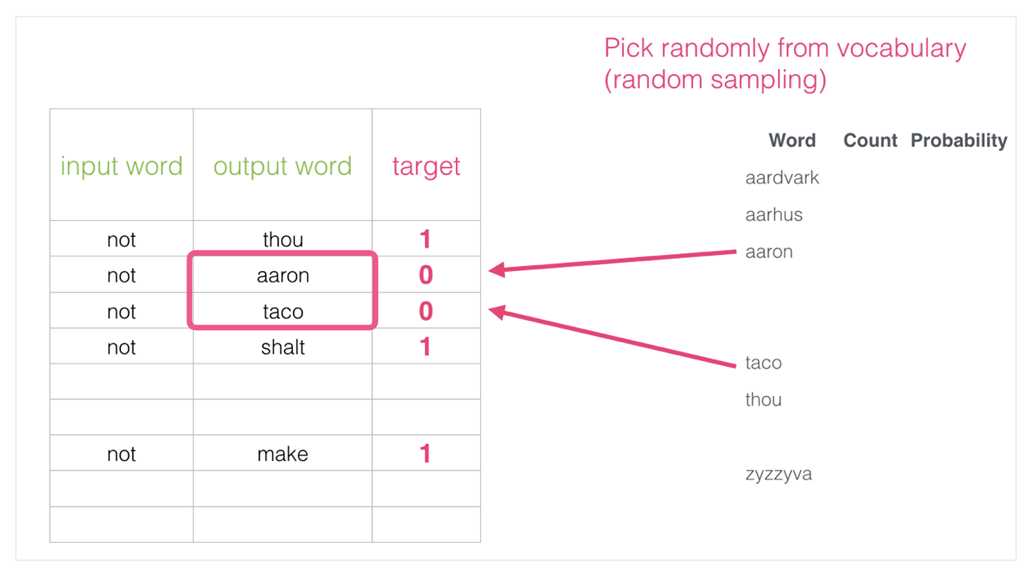

Пусть теперь наш корпус выглядит следующим образом:

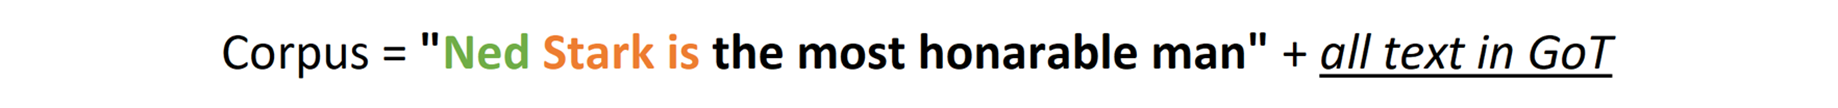

Установим гиперпараметры: размер окна — 2, количество отрицательных примеров — 3. Для первого слова "Ned" слово положительного класса — "Stark", слова отрицательного класса — "pimples", "zebra", "idiot".

### Forward

Умножение вектора на веса скрытого слоя

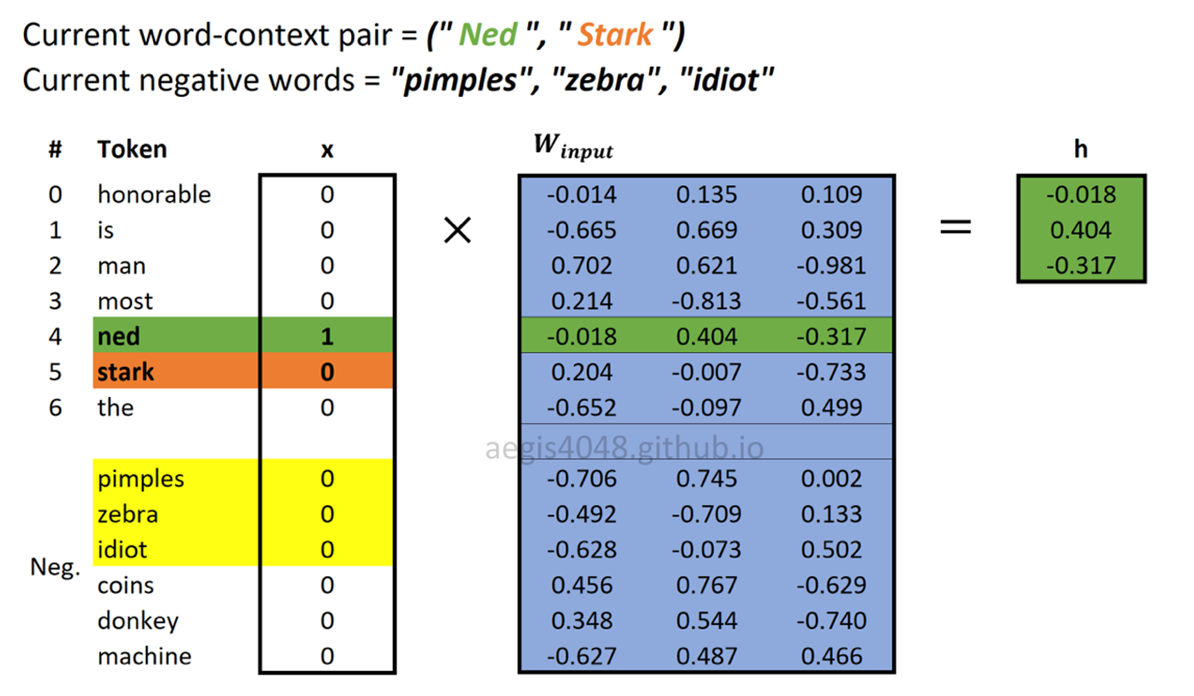

Умножение вектора (результата скрытого слоя) на веса выходного слоя. Применяем функцию активации (сигмоиду).

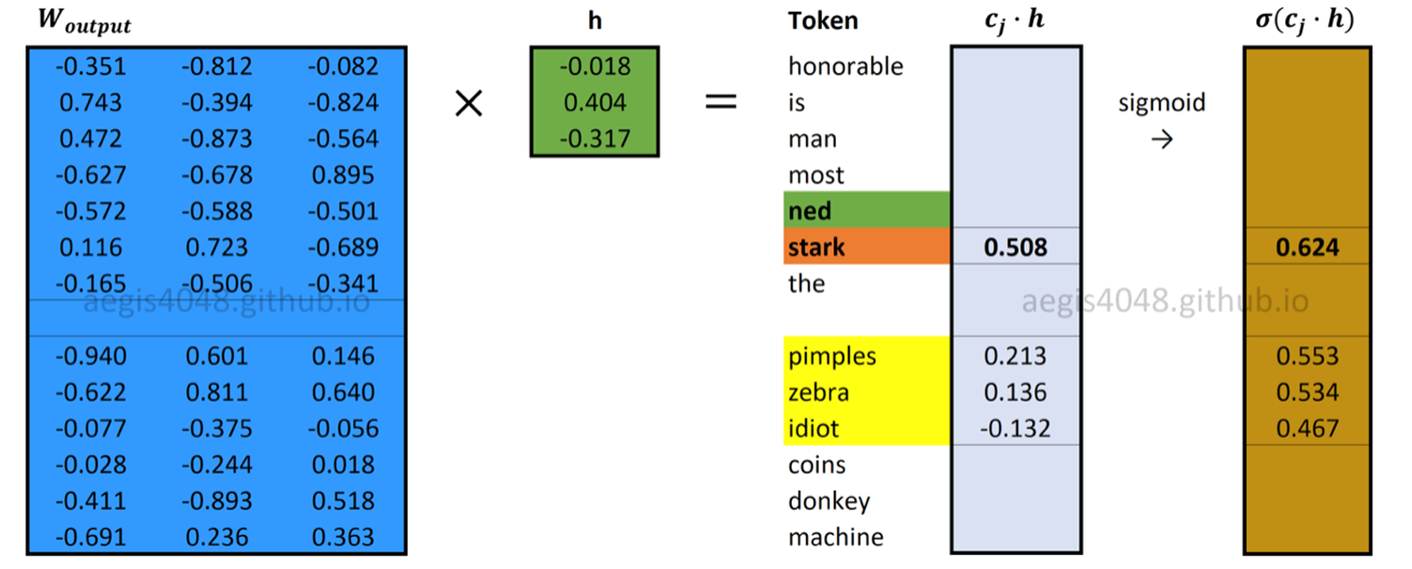

### Backward

Вычитаем из значение меток классов из получившихся вероятностей.

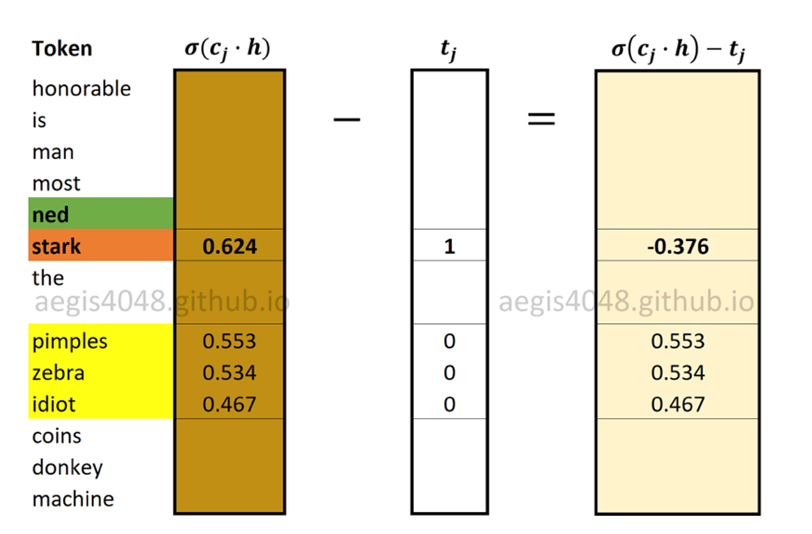

Подсчет градиента для $W_{input}$

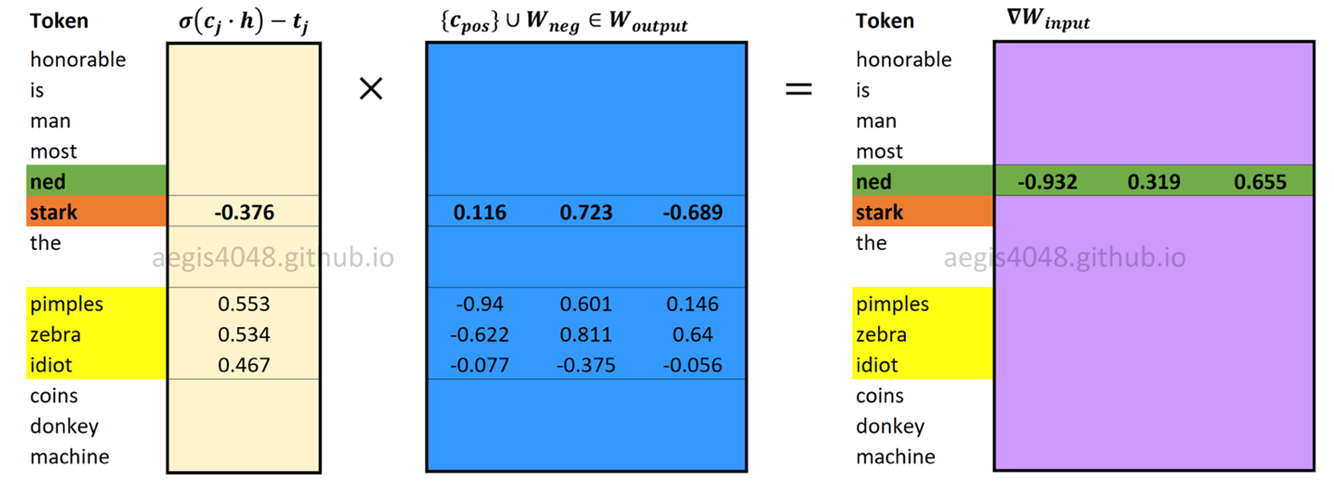

Подсчет градиента для $W^T_{output}$

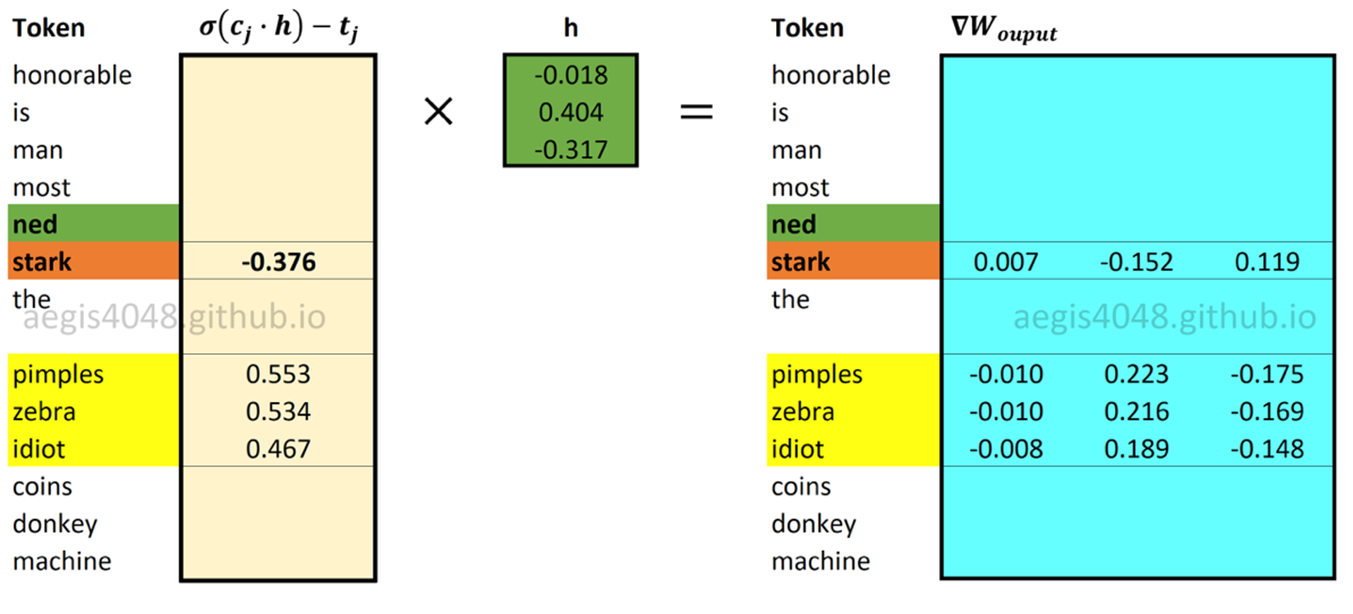

Обновление весов

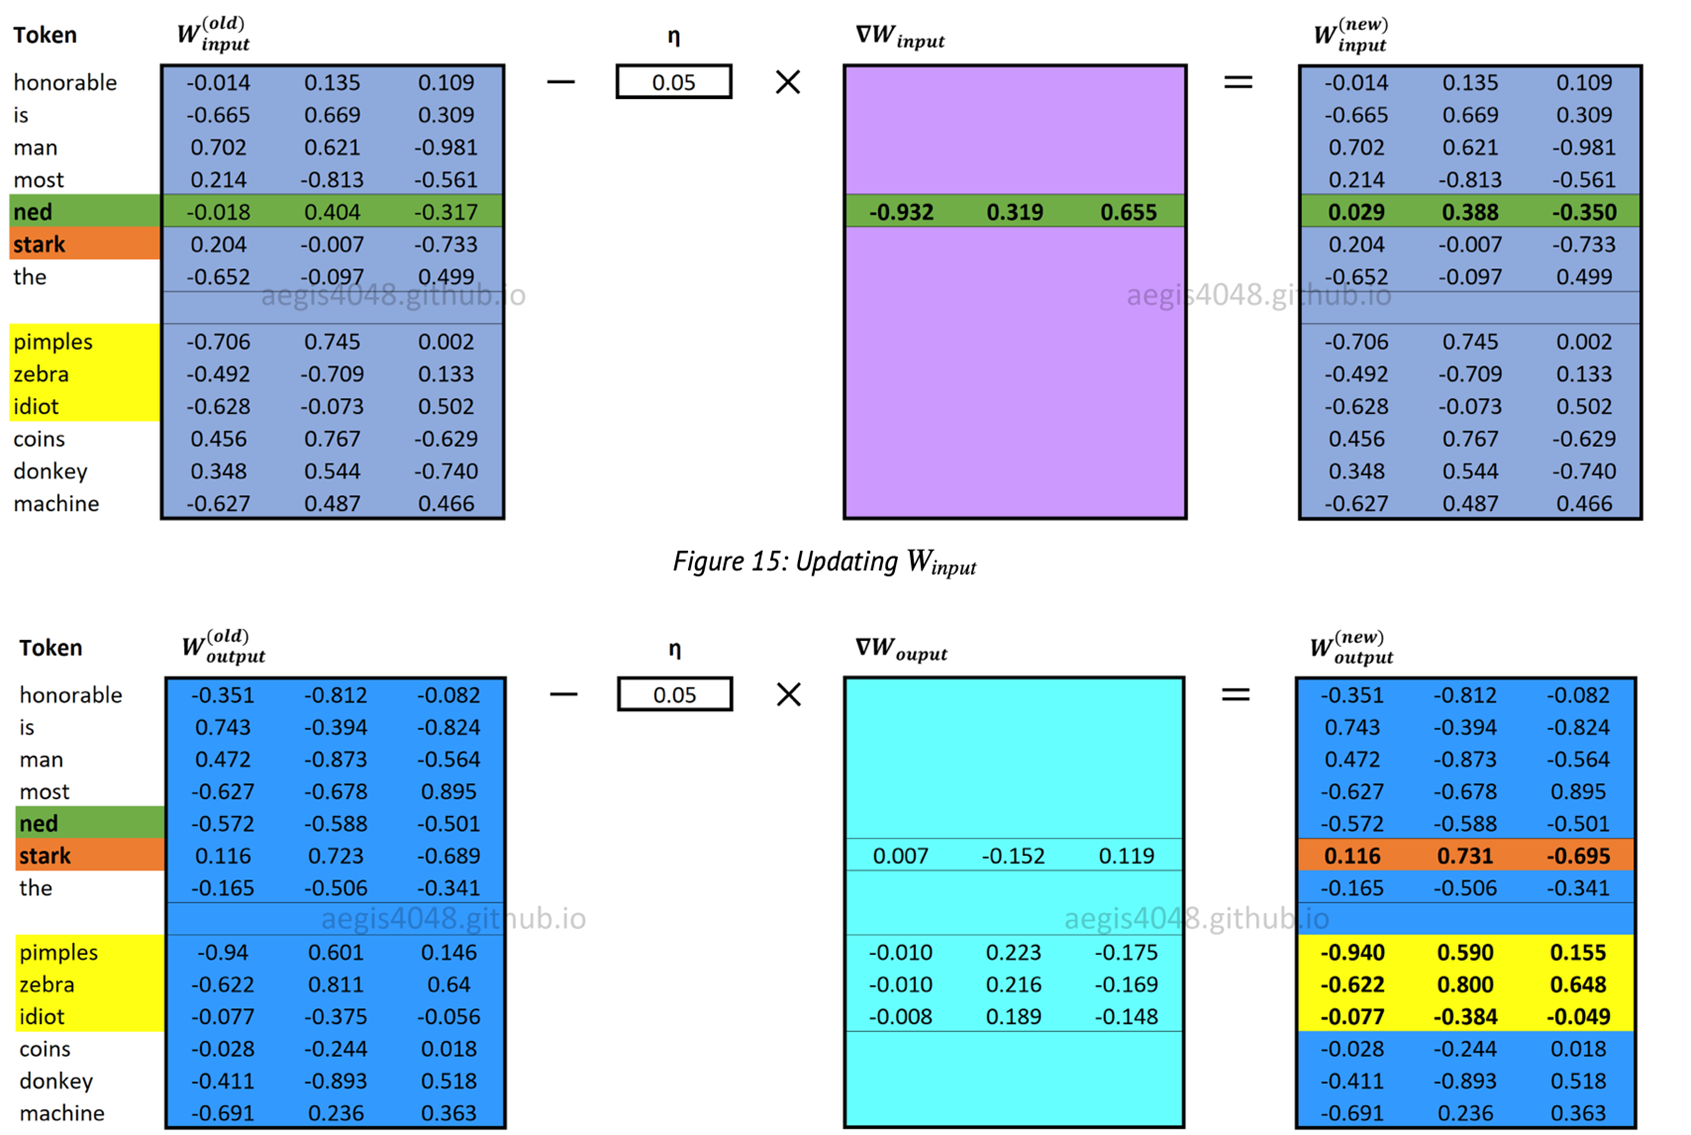

## fastText

📌 Какие недостатки есть у word2vec?

FastText позволяет получить векторные представления не для целых слов, а для n-грамм.

- Содержат морфологическую информацию
- Решение для слов, которых нет в словаре

[Оригинальная статья](https://arxiv.org/pdf/1607.04606v2.pdf)

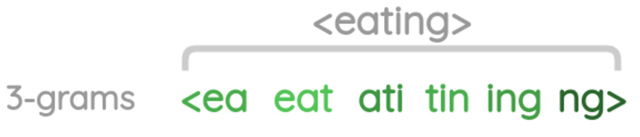

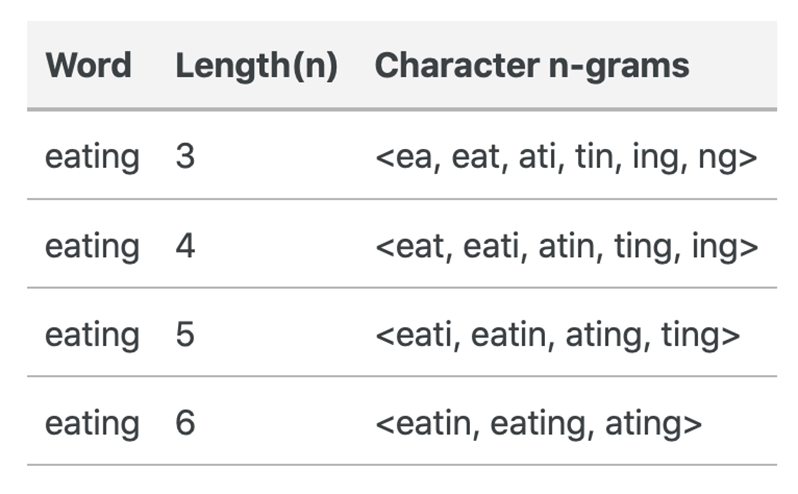

Размер n-грамм — гипермараметр. Все n-граммы ранжируются и берутся только самые частотные (первые несколько миллионов).

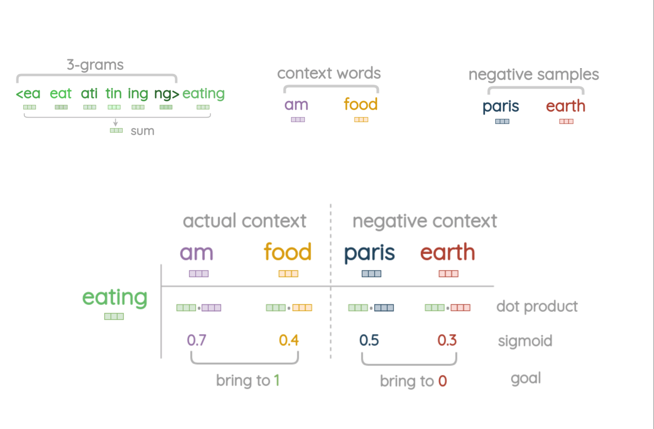